# Train smarter Naive Bayes model with labelled data

The running of this script creates new pickle object with Naive Bayes model. Periodically runs the notebook and replace the pickle file in object with a new one as it only gets better with more data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.naive_bayes import ComplementNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/vlado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('hn_topic_labelling.csv', header=None)
df.columns = ['index', 'text', 'naive_bayes_label', 'neural_net_label', 'checked_label']
df = df[['text', 'checked_label']]
df = df.dropna()
df.shape

(508, 2)

In [4]:
df

,text,checked_label
0,Fauci and his close colleagues (including the ...,AI/Data Science
1,LLVM doesn&#x27;t support all the CPU architec...,AI/Data Science
2,Autonomous cars might be possible for climates...,AI/Data Science
3,"Unfortunately, the reality is that we have no ...",AI/Data Science
4,"How much, how long, and what type? You’re not ...",AI/Data Science
...,...,...
503,Most of the domains ending with *ly(:?.com?) i...,web/mobile
504,Where is the source for the Java Benchmarks? A...,web/mobile
505,OK but that’s Apple. Brave needs Apple’s agre...,web/mobile
506,"Once the binaries come, it&#x27;s a matter of ...",web/mobile


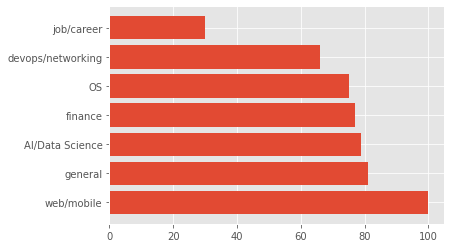

In [5]:
plt.figure(figsize=[6,4])
plt.barh(df['checked_label'].value_counts().index, df['checked_label'].value_counts());

We are going to have to clean the junk out of the text.

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    text = text.strip(' ')
    return text

def remove_stopwords(row):
    final_row = [w for w in row.split(' ') if w not in stopwords.words('english')]
    final_row = ' '.join(final_row)
    return final_row


In [7]:
df['text'] = df['text'].map(clean_text)
df['text'] = df['text'].map(remove_stopwords)

In [8]:
df

,text,checked_label
0,fauci close colleagues including current head ...,AI/Data Science
1,llvm x support cpu architectures gcc ones miss...,AI/Data Science
2,autonomous cars might possible climates withou...,AI/Data Science
3,unfortunately reality new data origin covid p...,AI/Data Science
4,much long type scientific,AI/Data Science
...,...,...
503,domains ending ly com immediately cause perhap...,web/mobile
504,source java benchmarks see docker file folder,web/mobile
505,ok apple brave needs apple agreement maybe got...,web/mobile
506,binaries come x matter finding ga tracking ids...,web/mobile


## Tf-IDF

Here we use Tf IDf which is a method based mainly on the frequency of the words. It's very good with the simpler models that we will be creating  here. 

In [9]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(df['text'])

In [10]:
x_train = x_train.toarray()

In [11]:
df['checked_label'].unique()

array(['AI/Data Science', 'devops/networking', 'finance', 'general',
       'job/career', 'OS', 'web/mobile'], dtype=object)

In [12]:
df['checked_label'] = df['checked_label'].map({'AI/Data Science': 0, 'devops/networking': 1, 'finance': 2, 'general': 3, 'job/career': 4, 'OS': 5, 'web/mobile': 6})
y_train = df['checked_label'] 

In [13]:
x_train.shape, y_train.shape

((508, 6373), (508,))

## Split into train - test 


In [14]:
# oversample = RandomOverSampler({0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250})
# x_train, y_train = oversample.fit_resample(x_train, y_train)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [16]:
x_train.shape, y_train.shape

((381, 6373), (381,))

In [17]:
x_test.shape, y_test.shape

((127, 6373), (127,))

## Naive Bayes

Very good with text data, sparse matrices and tf-idf.

In [18]:
nb = ComplementNB()

In [19]:
nb.fit(x_train, y_train)

ComplementNB()

In [20]:
preds = nb.predict(x_test)

In [21]:
def print_metrics(model, predictions):
    print(f'Train Accuracy: {model.score(x_train, y_train)}')
    print(f'Test Accuracy: {model.score(x_test, y_test)}')
    print(f'F1 score: {f1_score(predictions, y_test, average = "weighted")}')

In [22]:
print_metrics(nb, preds)

Train Accuracy: 0.9973753280839895
Test Accuracy: 0.6850393700787402
F1 score: 0.6878786973260221


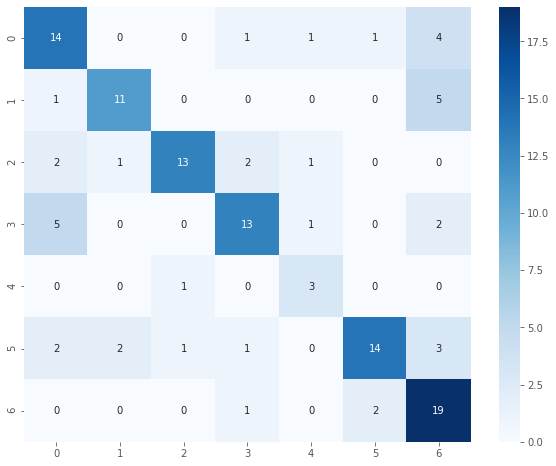

In [23]:
def show_confusion_matrix(predictions):
    conf_matrix = confusion_matrix(predictions, y_test)
    plt.figure(figsize=[10,8])
    sns.heatmap(conf_matrix, annot = True, fmt ='d',cmap = 'Blues');

show_confusion_matrix(preds)

## Save model

Let's create a pipeline that will ease the model when serves in production.

In [25]:
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])
pipe.fit(df['text'] , df['checked_label'] )

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])

In [26]:
def test_with_random_text(txt):
    txt = clean_text(txt)
    txt = remove_stopwords(txt)
    pred = pipe.predict([txt])
    return pred

In [27]:
pred = test_with_random_text('Windows is the worst OS there is. I hope people will soon see the excelence of Linux')
pred

array([5])

In [28]:
pred = test_with_random_text('This is all about politics.This is not in our labels so it should be general')
pred

array([3])

In [29]:
pred = test_with_random_text('AWS is the first cloud provider that i can think of. The label should be one')
pred

array([1])

In [30]:
import pickle
save_classifier = open("nb_topic_classifier.pickle","wb")
pickle.dump(pipe, save_classifier)
save_classifier.close()